In [72]:
import numpy as np
import pandas as pd
import textwrap
import string
import nltk
# import spacy
from nltk.tokenize import PunktSentenceTokenizer, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from collections import Counter
from heapq import nlargest
import warnings

nltk.download('stopwords')
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Professional\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
class BbcDataset(object):
    def __init__(self):
        self.DATA_DIR = "./data/bbc"
        self.classes = os.listdir(self.DATA_DIR)
        self.n_documents = len([os.path.join(path, name) for path, subdirectory, files in os.walk(self.DATA_DIR) for name in files])
        self.vectorizer = TfidfVectorizer(stop_words=stopwords.words("english"), norm="l1")

    def get_dataset(self):
        data = []
        for file in [os.path.join(path, name) for path, subdirectory, files in os.walk(self.DATA_DIR) for name in files]:
            label = file.split("\\")[-2]
            content = " ".join(open(file, encoding='utf-8', errors='ignore').read().splitlines())
            data.append((content, label))
        return data

    def get_pandas_alike_dataset(self):
        data = self.get_dataset()
        return pd.DataFrame(data, columns=["text", "label"])

    def get_random_class_sample(self):
        data = self.get_pandas_alike_dataset()
        data = data[data.label == np.random.choice(self.classes)]['text'].sample(random_state=42)
        textwrap.fill(data.iloc[0], replace_whitespace=False, fix_sentence_endings=True)
        return data

In [74]:
df = BbcDataset().get_pandas_alike_dataset()
df.head()

,text,label
0,Ad sales boost Time Warner profit Quarterly p...,business
1,Dollar gains on Greenspan speech The dollar h...,business
2,Yukos unit buyer faces loan claim The owners ...,business
3,High fuel prices hit BA's profits British Air...,business
4,Pernod takeover talk lifts Domecq Shares in U...,business


In [76]:
import re
import spacy
from pymystem3 import Mystem
from nltk.corpus import stopwords

regex = re.compile("[A-z]+")

mystopwords = stopwords.words('english')

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [77]:
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text, mystem=nlp):
    doc = mystem(text)
    return " ".join([token.lemma_ for token in doc])

In [78]:
df.text = df.text.apply(lemmatize)
df.text = df.text.str.lower()
df.text = df.text.apply(words_only)
df.text = df.text.apply(remove_stopwords)

In [79]:
from gensim import corpora
from gensim import models

texts = [df.text.iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below = 10)
corpus = [dictionary.doc2bow(text) for text in texts]

print(f"Number of unique tokens are : {len(dictionary)}")
print(f"Number of documents are : {len(corpus)}")

Number of unique tokens are : 4400
Number of documents are : 2225


In [80]:
lda = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, eta='auto', iterations = 20, passes = 5)

In [82]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

get_lda_topics(lda, 5)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,film,mr,people,good,win
1,us,government,use,win,go
2,bn,labour,mr,game,game
3,company,people,new,one,play
4,new,party,service,take,get
5,market,election,one,award,time
6,one,minister,technology,music,take
7,firm,blair,music,go,one
8,sale,could,mobile,people,first
9,good,new,get,new,last


In [83]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda, corpus, dictionary, mds='tsne')
pyLDAvis.display(vis_data)

На графике представлены 30 наиболее релевантных слов для каждого из 5-и топиков.  
Топик 1 - политика  
Топик 2 - технологии  
Топик 3 - бизнес  
Топик 4 - спорт  
Топик 5 - развлечения  

Представим еще также слова для каждого топика в виде облака

In [84]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show()

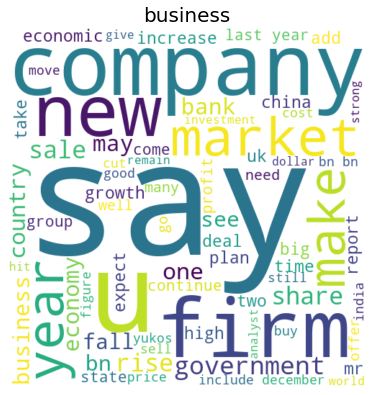

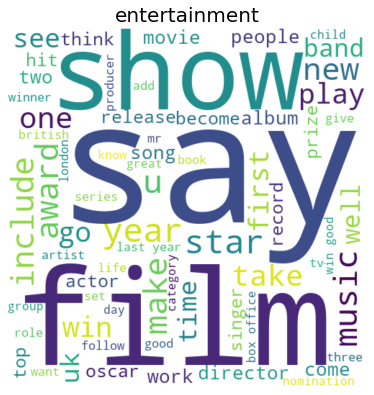

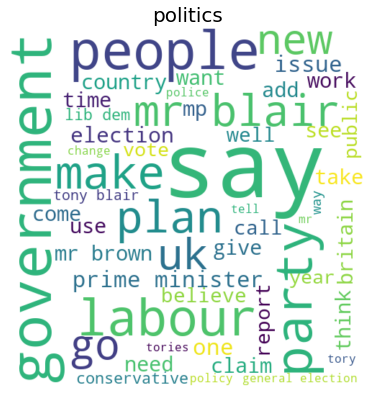

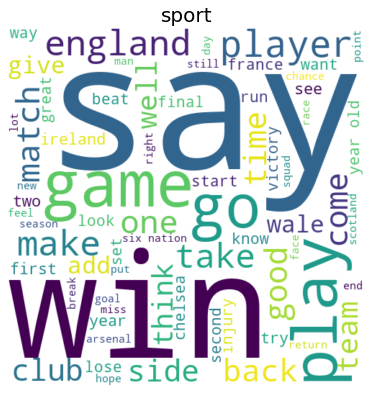

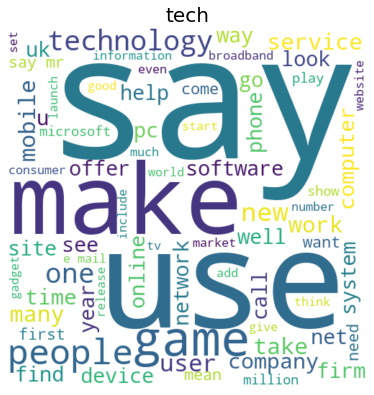

In [85]:
for label in df.label.unique():
    create_WordCloud(df.text.loc[df.label == label], label)